# Text Enhancement With Transformer

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from tqdm.auto import tqdm

import re
from nltk.corpus import stopwords
from collections import Counter
from string import punctuation

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , Dense , Embedding  , Dropout , LayerNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

# Data Preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/final year project dataset and code/Text Enhancement /Dataset/input.tsv", delimiter='\t' , nrows=100000)
df.columns = ["input", "label"]

In [ ]:
def remove_spaces(text) :
    text = re.sub(r" '(\w)",r"'\1",text)
    text = re.sub(r" \,",",",text)
    text = re.sub(r" \.+",".",text)
    text = re.sub(r" \!+","!",text)
    text = re.sub(r" \?+","?",text)
    text = re.sub(" n't","n't",text)
    text = re.sub("[\(\)\;\_\^\`\/]","",text)

    return text

In [ ]:
def decontract(text) :
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    return text

In [ ]:
def WrongSentence_preprocessing(col) :
    df[col] = df[col].astype(str)
    df[col] = df[col].apply(lambda x:x.lower())
    df[col] = df[col].apply(lambda x : re.sub("\n","",x))
    df[col] = df[col].apply(lambda x : remove_spaces(x))
    df[col] = df[col].apply(lambda x : re.sub(r"\.+",".",x))
    df[col] = df[col].apply(lambda x : re.sub(r"\!+","!",x))
    df[col] = df[col].apply(lambda x : decontract(x))
    df[col] = df[col].apply(lambda x: re.sub("[^A-Za-z\s]","",x))
    df[col] = df[col].apply(lambda x: x.replace("\s+"," "))
    df[col] = df[col].apply(lambda x: " ".join([word for word in x.split()]))
    return df

def TrueSentence_preprocessing(col) :
    df[col] = df[col].astype(str)
    df[col] = df[col].apply(lambda x:x.lower())
    df[col] = df[col].apply(lambda x : re.sub("\n","",x))
    df[col] = df[col].apply(lambda x : remove_spaces(x))
    df[col] = df[col].apply(lambda x : re.sub(r"\.+",".",x))
    df[col] = df[col].apply(lambda x : re.sub(r"\!+","!",x))
    df[col] = df[col].apply(lambda x : decontract(x))
    df[col] = df[col].apply(lambda x: re.sub("[^A-Za-z\s]","",x))
    df[col] = df[col].apply(lambda x: re.sub(r'\d','',x))
    df[col] = df[col].apply(lambda x: re.sub(r'\s+',' ',x))
    df[col] = df[col].apply(lambda x: re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,।]", "", x))
    df[col] = df[col].apply(lambda x: x.strip())
    df[col] = "<sos> " + df[col] + " <eos>"
    return df

In [ ]:
df = WrongSentence_preprocessing('input')
df = TrueSentence_preprocessing('label')

In [ ]:
df['input_len'] = [len(text.split()) for text in df.input]
df['label_len'] = [len(text.split()) for text in df.label]

In [ ]:
df = df[~(df['input_len'] < 5) & ~(df['input_len'] > 20)]
df = df[~(df['label_len'] < 5) & ~(df['label_len'] > 20)]

In [ ]:
df.head()

,input,label,input_len,label_len
0,the effect of widespread dud targets two face ...,<sos> sos the effect of widespread dud targets...,15,19
2,much many brands and sellers still in the market,<sos> sos many brands and sellers still in the...,9,12
3,this is is the latest maintenance release of s...,<sos> sos this is is the latest maintenance re...,9,13
6,momover these devices have been proven to help...,<sos> sos moreover these devices are proven to...,14,17
8,worthless involved is supporting for the movement,<sos> sos get involved and help the movement e...,7,10


# Most Words Used


In [ ]:
def MostWordsUsed(n_words) :
    all_text = ''.join(df['label'].values)

    words = all_text.split()

    # remove puncs
    puncs = list(punctuation)
    words = [word for word in words if word not in puncs]

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    word_count = Counter(words)

    top_words = word_count.most_common(n_words)

    return top_words

In [ ]:
top_words = MostWordsUsed(50)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]



# Text to Vector Transformation

This code  demonstrates a function for vectorizing text data from a DataFrame column using tokenization and padding.

In [ ]:
def Vectorization(col , MAXLEN = 20) :
    sents = df[col].tolist()

    # build vocabulary
    corpus = [word for text in df[col] for word in text.split()]
    vocab_size = len(Counter(corpus))

    tokenizer = Tokenizer(num_words=vocab_size , oov_token = "<OOV>" ,
                          filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n'
                         )

    tokenizer.fit_on_texts(sents)

    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Text Vectorization
    seqs = tokenizer.texts_to_sequences(sents)

    pad_seqs = pad_sequences(seqs , maxlen = MAXLEN , padding = 'post')

    return pad_seqs , tokenizer

In [ ]:
input_seqs , input_tokenizer = Vectorization('input')
label_seqs , label_tokenizer = Vectorization('label')

In [ ]:
label_sent = ' '.join([label_tokenizer.index_word[idx] for idx in label_seqs[15] if idx != 0])
print(f"{label_seqs[15]} \n\n {label_sent}")

[    2     2  2879    44     4 18602   115  8786     9    13     4   722
    26    43    78  1750     3     3     0     0] 

 sos sos checks if the oculus go headset is on the face or has been removed eos eos


In [ ]:
print(f"The size of the source vocab size : {len(input_tokenizer.word_index)}\n")
print(f"The size of the target vocab size : {len(label_tokenizer.word_index)}\n")

The size of the source vocab size : 58264

The size of the target vocab size : 47362



# Split the data

In [ ]:
x_train , x_val , y_train , y_val = train_test_split(input_seqs , label_seqs , train_size = 0.80, random_state = 42)

In [ ]:
x_train.shape , x_val.shape

((36833, 20), (9209, 20))

# Data Pipeline

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices((x_train , y_train))
train_set = train_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE , drop_remainder = True)

val_set = tf.data.Dataset.from_tensor_slices((x_val , y_val))
val_set = val_set.batch(BATCH_SIZE , drop_remainder = True)

In [ ]:
print(f"the size of the training set {len(train_set)} batches of {BATCH_SIZE}")

the size of the training set 287 batches of 128


In [ ]:
print(f"the size of the validation set {len(val_set)} batches of {BATCH_SIZE}")

the size of the validation set 71 batches of 128


# Build our Transformer

<b style = 'font-size : 24px; color : #34bf49; margin-left : 40%;'>Positional Encoding</b>
$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

<b>we can also apply position encoding using learnable parameters like embedding layer </b>

In [ ]:
def get_angles(pos , idx , embedding_dim) :
    # pos : position of the input in the sequence
    # idx : index of the dimension in the embedding vector
    # d-model : embedding dimension
    angle_rates = 1 / np.power(10000 , (2 * (idx // 2)) / np.float32(embedding_dim))

    return pos * angle_rates

In [ ]:
def positional_encoding(position , embedding_dim) :
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(embedding_dim)[np.newaxis, :], embedding_dim)

    # apply sin to even indices (2i)
    angle_rads[: , 0::2] = np.sin(angle_rads[: , 0::2])

    # apply consine to odd indices (2i + 1)
    angle_rads[: , 1::2] = np.cos(angle_rads[: , 1::2])

    pos_encoding  = angle_rads = angle_rads[np.newaxis , ...]

    return tf.cast(pos_encoding , dtype = tf.float32)

**test**

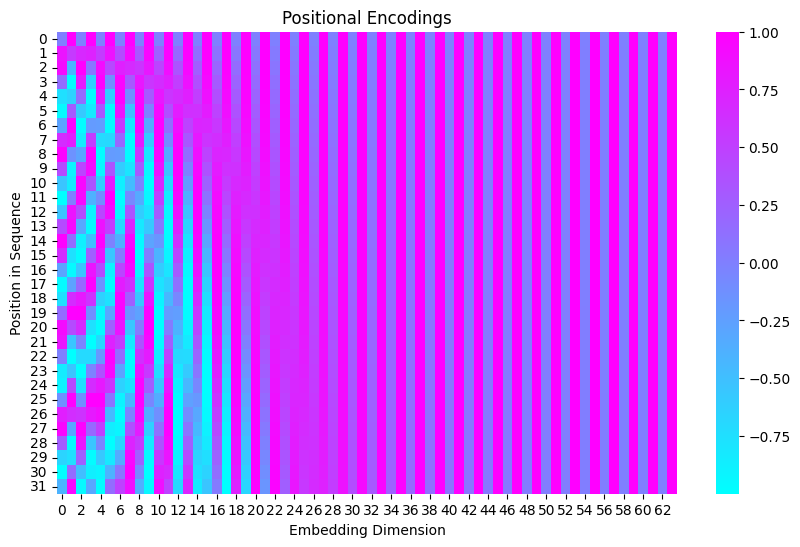

In [ ]:
# Generate positional encodings
pos_encodings = positional_encoding(32, 64)

# Visualize the encodings as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pos_encodings[0], cmap='cool')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encodings')
plt.show()

<b style = 'font-size : 24px; color : #34bf49; margin-left : 40%;'>Masking</b>

In [ ]:
def create_padding_mask(seq) :
    # Mask all the pad tokens in the batch of sequence.
    # It ensures that the model does not treat padding as the input.
    #The mask indicates where pad value 0 is present: it outputs a 1 at those locations,and a 0 otherwise.

    # seq shape : (batch_size , seqlen)  -> (batch_size , 1 , 1 , seq_len)
    seq = tf.cast(tf.math.equal(seq , 0) , tf.float32)

    return seq[: , tf.newaxis , tf.newaxis , :]

In [ ]:
def create_look_ahead_mask(size) : # size : seqlen
    # The look-ahead mask is used to mask the future tokens in a sequence. In other words,
    # the mask indicates which entries should not be used

    # a matrix with ones on the diagonal and zeros below the diagonal
    mask = 1 - tf.linalg.band_part(tf.ones((size , size)) , -1 , 0)

    return mask

**The create_masks function is used to create three different masks necessary for the attention mechanism in a transformer neural network model. The three masks are the encoder padding mask, the combined mask used in the first attention block, and the decoder padding mask used in the second attention block.**

**The enc_padding_mask is a binary mask used to indicate which elements of the input sequence are padding tokens, so that the attention mechanism will ignore these elements during processing. The dec_padding_mask is the same as the enc_padding_mask, but applied to the decoder input sequence.**

**The look_ahead_mask is used to mask out future tokens during training, so that the model can only use information from tokens it has already generated to make its next prediction.**

**Finally, the dec_target_padding_mask is used to mask out padding tokens in the decoder target sequence. The combined_mask is a combination of the look_ahead_mask and the dec_target_padding_mask, used in the first attention block to ensure that the decoder only uses information from previously generated tokens and not future ones, while ignoring padding tokens.**

In [ ]:
def create_masks(src , trg) :
    # encoder padding mask
    enc_padding_mask = create_padding_mask(src)

    # decoder padding mask
    dec_padding_mask = create_padding_mask(src)

    look_ahead_mask = create_look_ahead_mask(tf.shape(trg)[1])

    dec_trg_padding_mask = create_padding_mask(trg)

    combined_mask = tf.maximum(dec_trg_padding_mask , look_ahead_mask)

    return enc_padding_mask , combined_mask , dec_padding_mask

**test**

In [ ]:
create_padding_mask(tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]]))

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [ ]:
create_look_ahead_mask(3)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

<b style = 'font-size : 24px; color : #34bf49; margin-left : 40%;'>Self Attention</b>
$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [ ]:
def SelfAttention(q , k , v , mask) :
    # attention weights
    attention_logits = tf.matmul(q , k , transpose_b=True)

    # number of embedding values
    scaling =  tf.math.sqrt(tf.cast(tf.shape(k)[-1] , dtype = tf.float32))

    # scaled attention weights
    scaled_attention_logits = attention_logits / scaling

    # Apply mask to the attention weights (if mask is not None)
    if mask is not None :
        scaled_attention_logits += (mask * -1e9)

    # apply softmax
    attention_weights = tf.nn.softmax(scaled_attention_logits , axis = -1)

    # Compute the weighted sum of the value vectors using the attention weights
    output = tf.matmul(attention_weights , v)

    return output , attention_weights

**test**

In [ ]:
np.set_printoptions(suppress=True)
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)

temp_out , temp_attnW = SelfAttention(temp_q , temp_k , temp_v , None)

print(f"Attention weights:\n {temp_attnW}\n\n Attention weights shape: {temp_attnW.shape}\n")
print(f"Attention output:\n {temp_out}\n\n Attention output shape: {temp_out.shape}\n")

Attention weights:
 [[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]]

 Attention weights shape: (3, 4)

Attention output:
 [[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]]

 Attention output shape: (3, 2)



<b style = 'font-size : 24px; color : #34bf49; margin-left : 40%;'>Multi Head Attention</b>
<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer) :
    def __init__(self , embedding_dim , num_heads) :
        super(MultiHeadAttention , self).__init__()

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        # Embedding size needs to be divisible by heads
        assert self.embedding_dim % self.num_heads == 0


        self.head_dim = self.embedding_dim // self.num_heads

        self.queries = Dense(embedding_dim)
        self.keys = Dense(embedding_dim)
        self.values = Dense(embedding_dim)
        self.fc_out = Dense(embedding_dim)

    def split_heads(self , x , batch_size) :
        x = tf.reshape(x , (batch_size , -1 , self.num_heads , self.head_dim))
        return tf.transpose(x , perm = [0 , 2 , 1 , 3]) # (batch_size , num_heads , seqlen , head_dim)

    def call(self , q , k , v , mask = None) :
        batch_size = tf.shape(q)[0]

        # (q , k , v) shape: (batch_size , seqlen , embedding_dim)
        q = self.queries(q)
        k = self.keys(k)
        v = self.values(v)

        q = self.split_heads(q , batch_size) # (batch_size , num_heads , seqlen_q , head_dim)
        k = self.split_heads(k , batch_size) # (batch_size , num_heads , seqlen_k , head_dim)
        v = self.split_heads(v , batch_size) # (batch_size , num_heads , seqlen_v , head_dim)


        # scaled_attention shape : (batch_size , num_heads , seqlen_q , head_dim)
        # attention_weights shape : (batch_size , num_heads , seqlen_q , seqlen_k)
        scaled_attention , attention_weights = SelfAttention(q , k , v , mask)

        scaled_attention = tf.transpose(scaled_attention , perm = [0 , 2 , 1 , 3]) # (batch_size  , seqlen_q , num_heads , head_dim)

        # Concatenation of heads
        attention_output = tf.reshape(scaled_attention , (batch_size , -1 , self.embedding_dim)) # (batch_size , seqlen_q , embedding_dim = (num_heads * head_dim))

        out = self.fc_out(attention_output) # (batch_size , seqlen_q , embedding_dim)

        return out , attention_weights

**test**

In [ ]:
temp_MHA = MultiHeadAttention(512 , 8)
temp_input = tf.random.uniform((1, 60, 512))
temp_MHA_out , temp_MHA_attnW = temp_MHA(q = temp_input , k = temp_input , v = temp_input , mask = None)
temp_MHA_out.shape , temp_MHA_attnW.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

<b style = 'font-size : 24px; color : #34bf49; margin-left : 40%;'>Fully Connected Layer</b>

In [ ]:
def FC(embedding_dim , fc_dim) :
    model = tf.keras.Sequential([
        Dense(fc_dim , activation = 'relu') ,
        Dense(embedding_dim)
    ])

    return model

**test**

In [ ]:
temp_FC = FC(512 , 2048)
temp_FC(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

<b style = 'font-size : 24px; color : #34bf49; margin-left : 40%;'>Encoder</b>

In [ ]:
class EncoderBlock(tf.keras.layers.Layer) :
    def __init__(self , embedding_dim , num_heads , fc_dim , dropout_rate = 0.1) :
        super(EncoderBlock , self).__init__()

        self.MHA = MultiHeadAttention(embedding_dim , num_heads)

        self.fc = FC(embedding_dim , fc_dim)

        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self , x , training , mask) :
        # training : A boolean indicating whether the model is in training mode

        attn_out , _ = self.MHA(x , x , x , mask) # (batch_size , seqlen , embedding_dim)
        attn_out = self.dropout1(attn_out , training = training)

        out1 = self.norm1(x + attn_out) # (batch_size , seqlen , embedding_dim)

        fc_out = self.dropout2(self.fc(out1) , training = training) # (batch_size , seqlen , embedding_dim)

        enc_out = self.norm2(out1 + fc_out)  # (batch_size , seqlen , embedding_dim)

        return enc_out

In [ ]:
class Encoder(tf.keras.layers.Layer) :
    def __init__(
        self ,
        num_layers ,
        embedding_dim ,
        num_heads ,
        fc_dim ,
        src_vocab_size ,
        max_length ,
        dropout_rate = 0.1
    ) :
        super(Encoder , self).__init__()

        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        self.embedding = Embedding(src_vocab_size , embedding_dim)
        self.pos_encoding = positional_encoding(max_length , embedding_dim)

        self.enc_layers = [EncoderBlock(embedding_dim , num_heads , fc_dim , dropout_rate)
                          for _ in range(num_layers)]

        self.dropout = Dropout(dropout_rate)

    def call(self , x , training , mask) :
        seq_len = tf.shape(x)[1]

        x = self.embedding(x) # (batch_size , seqlen , embedding_dim)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32)) # Scale the embeddings by sqrt(embedding_dim)
        x += self.pos_encoding[: , :seq_len , :] # add the positional encoding
        x = self.dropout(x , training = training)

        for i in range(self.num_layers) :
            x = self.enc_layers[i](x , training , mask)

        return x # (batch_size , seqlen , embedding_dim)

**test**

In [ ]:
temp_encoder = Encoder(
    num_layers = 2 ,
    embedding_dim = 512 ,
    num_heads = 8 ,
    fc_dim = 2048 ,
    src_vocab_size = 8500 ,
    max_length = 10000
)

temp_in = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
temp_enc_out = temp_encoder(temp_in , training = False , mask = None)
temp_enc_out.shape

TensorShape([64, 62, 512])

<b style = 'font-size : 24px; color : #34bf49; margin-left : 40%;'>Decoder</b>

In [ ]:
class DecoderBlock(tf.keras.layers.Layer) :
    def __init__(self , embedding_dim , num_heads , fc_dim , dropout_rate = 0.1) :
        super(DecoderBlock , self).__init__()

        self.MHA1 = MultiHeadAttention(embedding_dim , num_heads)
        self.MHA2 = MultiHeadAttention(embedding_dim , num_heads)

        self.fc = FC(embedding_dim , fc_dim)

        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.norm3 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

    def call(self , x , enc_output , training , look_ahead_mask , padding_mask) :
        # enc_output shape : (batch_size , seqlen , embedding_dim)

        attn1 , attnW1 = self.MHA1(x , x , x , look_ahead_mask)
        attn1 = self.dropout1(attn1 , training = training)
        out1 = self.norm1(attn1 + x) # (batch_size , seqlen , embedding_dim)

        attn2 , attnW2 = self.MHA2(out1 , enc_output , enc_output , padding_mask)
        attn2 = self.dropout2(attn2 , training = training)
        out2 = self.norm2(attn2 + out1) # (batch_size , seqlen , embedding_dim)

        fc_out = self.dropout3(self.fc(out2) , training = training)

        dec_out = self.norm3(fc_out + out2) # (batch_size , seqlen , embedding_dim)

        return dec_out , attnW1 , attnW2

In [ ]:
class Decoder(tf.keras.layers.Layer) :
    def __init__(
        self ,
        num_layers ,
        embedding_dim ,
        num_heads ,
        fc_dim ,
        trg_vocab_size ,
        max_length ,
        dropout_rate = 0.1
    ) :
        super(Decoder , self).__init__()

        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        self.embedding = Embedding(trg_vocab_size , embedding_dim)
        self.pos_encoding = positional_encoding(max_length , embedding_dim)

        self.dec_layers = [DecoderBlock(embedding_dim , num_heads , fc_dim , dropout_rate)
                          for _ in range(num_layers)]

        self.dropout = Dropout(dropout_rate)

    def call(self , x , enc_output , training , look_ahead_mask , padding_mask) :
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x) # (batch_size , seqlen , embedding_dim)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32)) # Scale the embeddings by sqrt(embedding_dim)
        x += self.pos_encoding[: , :seq_len , :] # add the positional encoding
        x = self.dropout(x , training = training)

        for i in range(self.num_layers) :
            x , attnW1 , attnW2 = self.dec_layers[i](x , enc_output , training , look_ahead_mask , padding_mask)


        attention_weights['decoder_layer{}_block1'.format(i+1)] = attnW1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = attnW2

        return x, attention_weights

**test**

In [ ]:
temp_decoder = Decoder(
    num_layers = 2 ,
    embedding_dim = 512 ,
    num_heads = 8 ,
    fc_dim = 2048 ,
    trg_vocab_size = 8000 ,
    max_length = 5000
)

temp_dec_in = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)
temp_dec_out , temp_dec_attnW = temp_decoder(
    temp_dec_in ,
    temp_enc_out ,
    training = False ,
    look_ahead_mask = None,
    padding_mask = None
)

temp_dec_out.shape , temp_dec_attnW['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

<b style = 'font-size : 24px; color : #34bf49; margin-left : 40%;'>Put it together</b>
<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

In [ ]:
class Transformer(Model) :
    def __init__(
        self ,
        num_layers ,
        embedding_dim ,
        num_heads ,
        fc_dim ,
        src_vocab_size ,
        trg_vocab_size ,
        src_max_length ,
        trg_max_length ,
        dropout_rate = 0.1
    ) :
        super(Transformer , self).__init__()

        self.encoder = Encoder(
            num_layers ,
            embedding_dim ,
            num_heads ,
            fc_dim ,
            src_vocab_size ,
            src_max_length ,
            dropout_rate
        )

        self.decoder = Decoder(
            num_layers ,
            embedding_dim ,
            num_heads ,
            fc_dim ,
            trg_vocab_size ,
            trg_max_length ,
            dropout_rate
        )

        self.fc_out = Dense(trg_vocab_size)

    def call(
        self ,
        src ,
        trg ,
        training ,
        enc_padding_mask ,
        look_ahead_mask ,
        dec_padding_mask
    ) :

        enc_output = self.encoder(src , training , enc_padding_mask)

        dec_output , attention_weights = self.decoder(
                            trg , enc_output , training , look_ahead_mask, dec_padding_mask)

        out = self.fc_out(dec_output)

        return out , attention_weights

In [ ]:
# set hyperparameters
EPOCHS = 100
EMBEDDING_DIM = 256
FC_DIM = 512
NUM_LAYERS = 4
NUM_HEADS = 8
DROPOUT_RATE = 0.1
SRC_VOCAB_SIZE = len(input_tokenizer.word_index) # 64896
TRG_VOCAB_SIZE = len(label_tokenizer.word_index) # 52351
SRC_MAXLEN = SRC_VOCAB_SIZE
TRG_MAXLEN = TRG_VOCAB_SIZE

model = Transformer(
    NUM_LAYERS ,
    EMBEDDING_DIM ,
    NUM_HEADS ,
    FC_DIM ,
    SRC_VOCAB_SIZE ,
    TRG_VOCAB_SIZE ,
    SRC_MAXLEN ,
    TRG_MAXLEN ,
    DROPOUT_RATE
)

**test**

In [ ]:
temp_src = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_trg = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)
temp_trg_out , _ = model(temp_src, temp_trg, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)
model.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  17024000  
                                                                 
 decoder_3 (Decoder)         multiple                  15287808  
                                                                 
 dense_205 (Dense)           multiple                  12172034  
                                                                 
Total params: 44483842 (169.69 MB)
Trainable params: 44483842 (169.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Learning Rate Scheduler

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule) :
    def __init__(self , embedding_dim , warmup_steps = 4000) :
        super(CustomSchedule , self).__init__()

        self.embedding_dim = tf.cast(embedding_dim , dtype = tf.float32)
        self.warmup_steps = tf.cast(warmup_steps , dtype = tf.float32)

    def __call__(self , step) :
        step = tf.cast(step , dtype = tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1 , arg2)

Text(0.5, 0, 'Train Step')

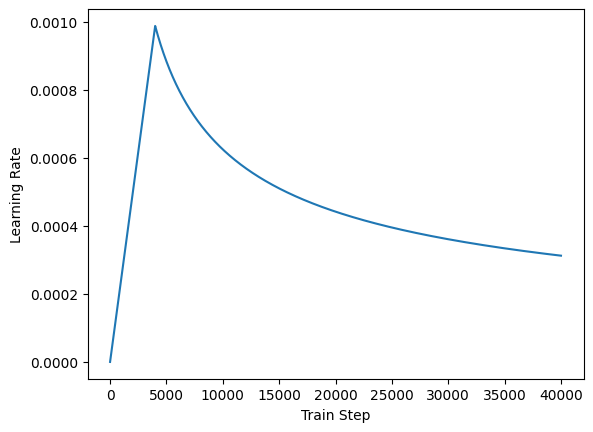

In [ ]:
temp_learning_rate_schedule = CustomSchedule(EMBEDDING_DIM)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss , Optimizer and Metrics

In [ ]:
LR = CustomSchedule(EMBEDDING_DIM)

optimizer = Adam(LR, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# This is done to diminish the output prediction of 0
# which has no importance and is used only for padding the inputs
def criterion(real , pred) :
    # Create a mask to exclude the padding tokens
    mask = tf.math.logical_not(tf.math.equal(real , 0))

    # Compute the loss value using the loss object
    loss = loss_object(real , pred)

    # Apply the mask to exclude the padding tokens
    mask = tf.cast(mask , dtype = loss.dtype)

    loss *= mask

    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

# Train our model

In [ ]:
@tf.function
def train_step(src , trg) :
    decoder_input = trg[: , :-1]
    trg_reals = trg[: , 1:]

    enc_padding_mask , combined_mask , dec_padding_mask = create_masks(src , decoder_input)

    with tf.GradientTape() as tape :
        preds , _ = model(
            src ,
            decoder_input ,
            True ,
            enc_padding_mask ,
            combined_mask ,
            dec_padding_mask
        )

        loss = criterion(trg_reals , preds)

    gradients = tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(gradients , model.trainable_variables))

    train_loss(loss)


@tf.function
def val_step(src , trg) :
    decoder_input = trg[: , :-1]
    trg_reals = trg[: , 1:]

    enc_padding_mask , combined_mask , dec_padding_mask = create_masks(src , decoder_input)

    preds , _ = model(
        src ,
        decoder_input ,
        False ,
        enc_padding_mask ,
        combined_mask ,
        dec_padding_mask
    )

    loss = criterion(trg_reals , preds)

    val_loss(loss)

In [ ]:
with tf.device("/GPU:0") :
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(EPOCHS)) :
        train_loss.reset_states()
        val_loss.reset_states()

        for src , trg in train_set :
            train_step(src , trg)

        for src , trg in val_set :
            val_step(src , trg)

        train_losses.append(train_loss.result())
        val_losses.append(val_loss.result())

        if (epoch + 1) % 10 == 0 :
            print(f"\n[Epoch :  {epoch+1}/{EPOCHS}] [Train Loss : {train_losses[-1]:0.2f}] [Validation Loss : {val_losses[-1]:0.2f}]\n")

  0%|          | 0/100 [00:00<?, ?it/s]


[Epoch :  10/100] [Train Loss : 2.10] [Validation Loss : 3.24]


[Epoch :  20/100] [Train Loss : 0.43] [Validation Loss : 3.61]


[Epoch :  30/100] [Train Loss : 0.16] [Validation Loss : 3.87]


[Epoch :  40/100] [Train Loss : 0.10] [Validation Loss : 3.89]


[Epoch :  50/100] [Train Loss : 0.09] [Validation Loss : 3.92]


[Epoch :  60/100] [Train Loss : 0.08] [Validation Loss : 3.93]


[Epoch :  70/100] [Train Loss : 0.07] [Validation Loss : 3.92]


[Epoch :  80/100] [Train Loss : 0.11] [Validation Loss : 3.93]


[Epoch :  90/100] [Train Loss : 0.13] [Validation Loss : 3.89]


[Epoch :  100/100] [Train Loss : 0.05] [Validation Loss : 4.02]



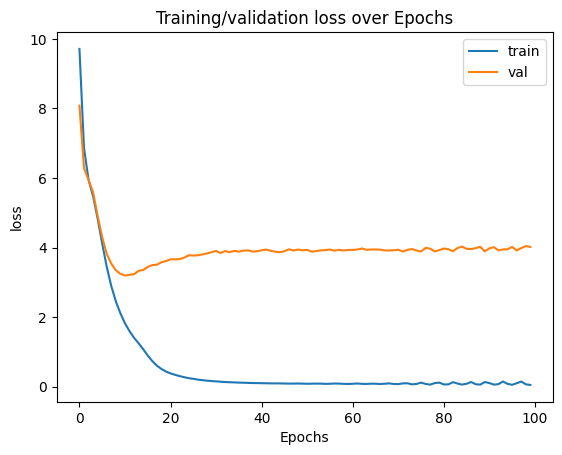

In [ ]:
plt.plot(train_losses , label='train')
plt.plot(val_losses , label='val')
plt.title('Training/validation loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

# Evaluate

In [ ]:
def evalute(sent) :
    sentence = input_tokenizer.texts_to_sequences([sent])
    sentence = pad_sequences(sentence , maxlen = 20 , padding = 'post')

    input = tf.convert_to_tensor(np.array(sentence) , dtype = tf.int64)

    decoder_input = label_tokenizer.texts_to_sequences(['sos'])
    decoder_input = tf.convert_to_tensor(np.array(decoder_input) , dtype = tf.int64)

    for i in range(20) : # maxlen = 20
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(input, decoder_input)

        preds , _ = model(
            input ,
            decoder_input ,
            False ,
            enc_padding_mask ,
            combined_mask ,
            dec_padding_mask
        )

        preds = preds[: , -1: , :] # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(preds, axis=-1), tf.int64)

        if predicted_id == label_tokenizer.word_index['eos'] :
            return tf.squeeze(decoder_input , axis = 0)

        decoder_input = tf.concat([decoder_input, predicted_id], axis=1)

    return tf.squeeze(decoder_input, axis=0)

In [ ]:
test_sample = df.sample(1000)

In [ ]:
x_test = test_sample['input'].tolist()
y_test = test_sample['label'].tolist()

In [ ]:
result = evalute(x_test[10])

In [ ]:
x_test[10] , y_test[10]

('to work with gather view see opening a gather view',
 '<sos> sos to work with gather view see opening a gather view eos <eos>')

In [ ]:
pred_sent = ' '.join([label_tokenizer.index_word[idx] for idx in result.numpy() if idx != 0 and idx != 2])
print(f"{result} \n\n {pred_sent}")

[   2    2    5   85   14    4  280  181 1233    8 4667  181] 

 to work with the following view opening a gather view


In [ ]:
print(f"Input sentence : {x_test[10]}")
print(f"Actual correction : {y_test[10]}")
print(f"Predicted correction : {pred_sent}\n")

Input sentence : to work with gather view see opening a gather view
Actual correction : <sos> sos to work with gather view see opening a gather view eos <eos>
Predicted correction : to work with the following view opening a gather view



In [ ]:
for idx , (src_sent , trg_sent) in enumerate(zip(x_test[-10:] , y_test[-10:])) :
    result = evalute(src_sent)
    pred_sent = ' '.join([label_tokenizer.index_word[idx] for idx in result.numpy() if idx != 0 and idx != 2])
    print(f"Input sentence {idx+1} : {src_sent}")
    print(f"Actual correction {idx+1} : {trg_sent}")
    print(f"Predicted correction {idx+1} : {pred_sent}\n")

Input sentence 1 : noneushield data sentinel currently olny supports ntfspartitions
Actual correction 1 : <sos> sos no neushield data sentinel currently only supports ntfs partitions eos <eos>
Predicted correction 1 : no neushield data sentinel currently only supports ntfs partitions

Input sentence 2 : change doesnt always have to be a bad point
Actual correction 2 : <sos> sos change doesnt always have to be a bad thing eos <eos>
Predicted correction 2 : change doesnt always have to be a bad thing

Input sentence 3 : oh my this is as an organizational heaven
Actual correction 3 : <sos> sos oh my this is like organizational heaven eos <eos>
Predicted correction 3 : oh my is as an organizational heavens heaven

Input sentence 4 : and he helps user reviews online
Actual correction 4 : <sos> sos based on user reviews online eos <eos>
Predicted correction 4 : based on user reviews online

Input sentence 5 : easy diciresilence that you might say
Actual correction 5 : <sos> sos easy decision